## 이천시홈페이지 업무추진비 크롤링

In [247]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from time import sleep

chrome_options = Options()
chrome_options.add_experimental_option("detach", True)

service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

driver.get("https://opengov.icheon.go.kr/ic-home/dashboard/pagemove.do?pid=9&uri=/sub01_04&group=group1")



In [ ]:
# 검색 아이콘을 클릭하여 검색 창을 확장합니다.
from openpyxl import Workbook
from selenium.common.exceptions import StaleElementReferenceException

# 엑셀 만드는 역할을 합니다.
wb = Workbook()

# 엑셀에서 워크시트 생성
ws = wb.active
ws.title = '맛집'

title = ['가게 이름']
ws.append(title)

# 1년 옵션으로 바꿔주는 데이터
driver.find_element(By.CSS_SELECTOR, '#js__searchDateSet > label:nth-child(8)').click()
driver.find_element(By.CSS_SELECTOR, '#searchButton').click()


for page_number in range(1, 11):

    # 다음 페이지 이동
    if page_number != 1 :
        ele = driver.find_element(By.CSS_SELECTOR, f'#pagination > a:nth-child({page_number})')
        # print("page_number",page_number, ele.text)
        ele.click()
        sleep(0.1)
        
        

    # 페이지 로딩이 끝나면 알아서 다음 동작을 시작해준다.
    driver.implicitly_wait(10)
    elements = driver.find_element(By.ID, 'dataList')
    page_data= elements.find_elements(By.CSS_SELECTOR, '.tal > a')
    page_size=len(page_data)
    # print("페이지목록 개수", page_size)
    # n번째 페이지의 목록들을 순서대로 하나씩 고른다.
    for page_element in range(0, page_size):
        sleep(0.2)
        elements = driver.find_element(By.ID, 'dataList')
        page_data= elements.find_elements(By.CSS_SELECTOR, '.tal > a')
        
        element = page_data[page_element]
        element.click()
        sleep(0.5)
        WebDriverWait(driver, 10).until(EC.staleness_of(element))
    
        
        
        restaurant_size = driver.find_elements(By.CSS_SELECTOR, '._allBox tbody > tr')
        
        for i in range(1, len(restaurant_size)+1):
            restaurant = driver.find_element(By.CSS_SELECTOR, f'#site-content > div > div:nth-child(2) > div > table > tbody > tr:nth-child({i}) > td:nth-child(3)').text
            ws.append([restaurant])

        back_click = driver.find_element(By.CLASS_NAME, 'doc-warp')
        back_click.click()
        sleep(1.5)
        
        # 1년 옵션으로 바꿔주는 데이터
        driver.find_element(By.CSS_SELECTOR, '#js__searchDateSet > label:nth-child(8)').click()
        sleep(0.5)
        driver.find_element(By.CSS_SELECTOR, '#searchButton').click()
        sleep(1)
        # 다시 현재 페이지로 이동
        if page_number == 1 : continue
        driver.implicitly_wait(30)
        next_page_button = WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, f'#pagination > a:nth-child({page_number})'))
        )
        next_page_button.click()
        sleep(1)
        WebDriverWait(driver, 10).until(EC.staleness_of(next_page_button))
        


wb.save('restaurant.xlsx')

## 데이터 정제

In [251]:
import pandas as pd
df = pd.read_excel('restaurant.xlsx')

df

,가게 이름
0,육탐미
1,주식회사 더크레프츠
2,주공정육솥뚜겅삼겹살
3,현대가든
4,중리골
...,...
2084,주식회사 인도하우스
2085,삽다리막창골
2086,옛날통닭
2087,NC이천점


In [252]:
# 필터링 처리
filt = (df['가게 이름'] == "○○○") | (df['가게 이름'] == '') | (df['가게 이름'].str.contains('롯데마트'))
df[filt].index
df = df.drop(index=df[filt].index)

In [255]:
# 중복된 '가게 이름'의 갯수를 새로운 열로 추가
df['총합'] = df.groupby('가게 이름')['가게 이름'].transform('count')

# 중복 횟수를 기준으로 랭킹을 부여하고 오름차순으로 정렬
df['랭킹'] = df['총합'].rank(ascending=False, method='min')

# 결과 출력
sorted_df = df.sort_values(by='랭킹')

In [257]:
df_unique = sorted_df.drop_duplicates(subset=['가게 이름'])
# 중복제거
df_unique

,가게 이름,총합,랭킹
1036,느티나무집,39.0,1.0
2020,모가단위농협,34.0,40.0
538,정다함,31.0,74.0
387,어향미가,31.0,74.0
1767,관촌순두부,30.0,136.0
...,...,...,...
1528,만우생고기식당,1.0,1578.0
1529,김** 외 1인,1.0,1578.0
1534,조개사랑,1.0,1578.0
0,육탐미,1.0,1578.0


In [258]:
df_unique_reset_index = df_unique.reset_index(drop=True)

df_unique_reset_index


,가게 이름,총합,랭킹
0,느티나무집,39.0,1.0
1,모가단위농협,34.0,40.0
2,정다함,31.0,74.0
3,어향미가,31.0,74.0
4,관촌순두부,30.0,136.0
...,...,...,...
691,만우생고기식당,1.0,1578.0
692,김** 외 1인,1.0,1578.0
693,조개사랑,1.0,1578.0
694,육탐미,1.0,1578.0


In [259]:
df_unique_reset_index['랭킹'] = df_unique_reset_index['총합'].rank(ascending=False, method='dense')

df = df_unique_reset_index

,가게 이름,총합,랭킹
0,느티나무집,39.0,1.0
1,모가단위농협,34.0,2.0
2,정다함,31.0,3.0
3,어향미가,31.0,3.0
4,관촌순두부,30.0,4.0
...,...,...,...
691,만우생고기식당,1.0,27.0
692,김** 외 1인,1.0,27.0
693,조개사랑,1.0,27.0
694,육탐미,1.0,27.0


In [261]:
df = df.set_index('가게 이름')
df

,총합,랭킹
가게 이름,,
느티나무집,39.0,1.0
모가단위농협,34.0,2.0
정다함,31.0,3.0
어향미가,31.0,3.0
관촌순두부,30.0,4.0
...,...,...
만우생고기식당,1.0,27.0
김** 외 1인,1.0,27.0
조개사랑,1.0,27.0


In [51]:
df.to_excel('restaurant_01.xlsx')

## 구글 맵 크롤링

In [245]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from time import sleep

chrome_options = Options()
chrome_options.add_experimental_option("detach", True)

service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

driver.get("https://www.google.com/maps/?authuser=0&entry=ttu")

In [ ]:
from openpyxl import Workbook
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import NoSuchElementException
import pandas as pd

df = pd.read_excel('restaurant_01.xlsx', index_col='가게 이름')
x = 0
lst = []
for store in df.index:
    x = x + 1
    search_input=driver.find_element(By.CLASS_NAME, 'searchboxinput')
    search_input.send_keys('이천 '+store)
    search_input.send_keys(Keys.RETURN)
    sleep(1)
    
    try:
        score = driver.find_element(By.CSS_SELECTOR, 'div > div.fontBodyMedium.dmRWX > div.F7nice > span:nth-child(1) > span:nth-child(1)').text
    except NoSuchElementException as e:
        driver.find_element(By.CLASS_NAME, 'hfpxzc').click()
        sleep(1)
        score = driver.find_element(By.CSS_SELECTOR, 'div > div.fontBodyMedium.dmRWX > div.F7nice > span:nth-child(1) > span:nth-child(1)').text

    lst += score
    search_input.clear()
    if x == 35: break


## 데이터 정제

In [217]:

# 리스트를 3개씩 묶어서 문자열로 합치기
result_string = ' '.join([''.join(lst[i:i+3]) for i in range(0, len(lst), 3)])

# 공백으로 분리하여 리스트 생성
result_list = result_string.split()

# '가게 이름'과 '구글평점' 컬럼을 가진 데이터프레임 생성
df_google_ratings = pd.DataFrame({'가게 이름': store_name[:len(result_list)], '구글평점': result_list})

# 결과 출력
df_google_ratings = df_google_ratings.set_index('가게 이름')
df_google_ratings

,구글평점
가게 이름,
느티나무집,4.1
정다함,3.8
어향미가,3.4
관촌순두부,4.1
두레손만두,4.2
미소원정육식당,4.3
서경한우프라자,3.0
미반,4.2
황금룡,4.2


## 이천시 업무추진비 그래프와 구글평점 관계 확인

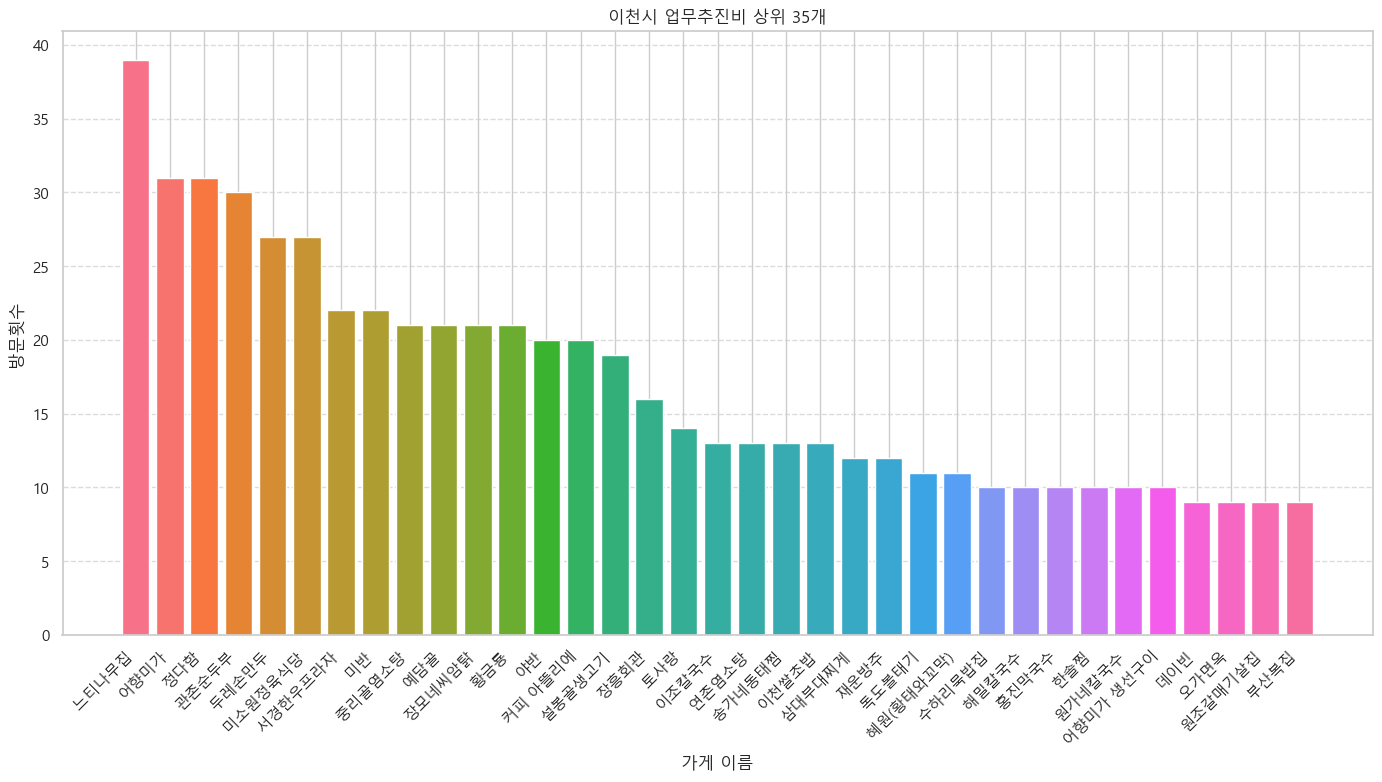

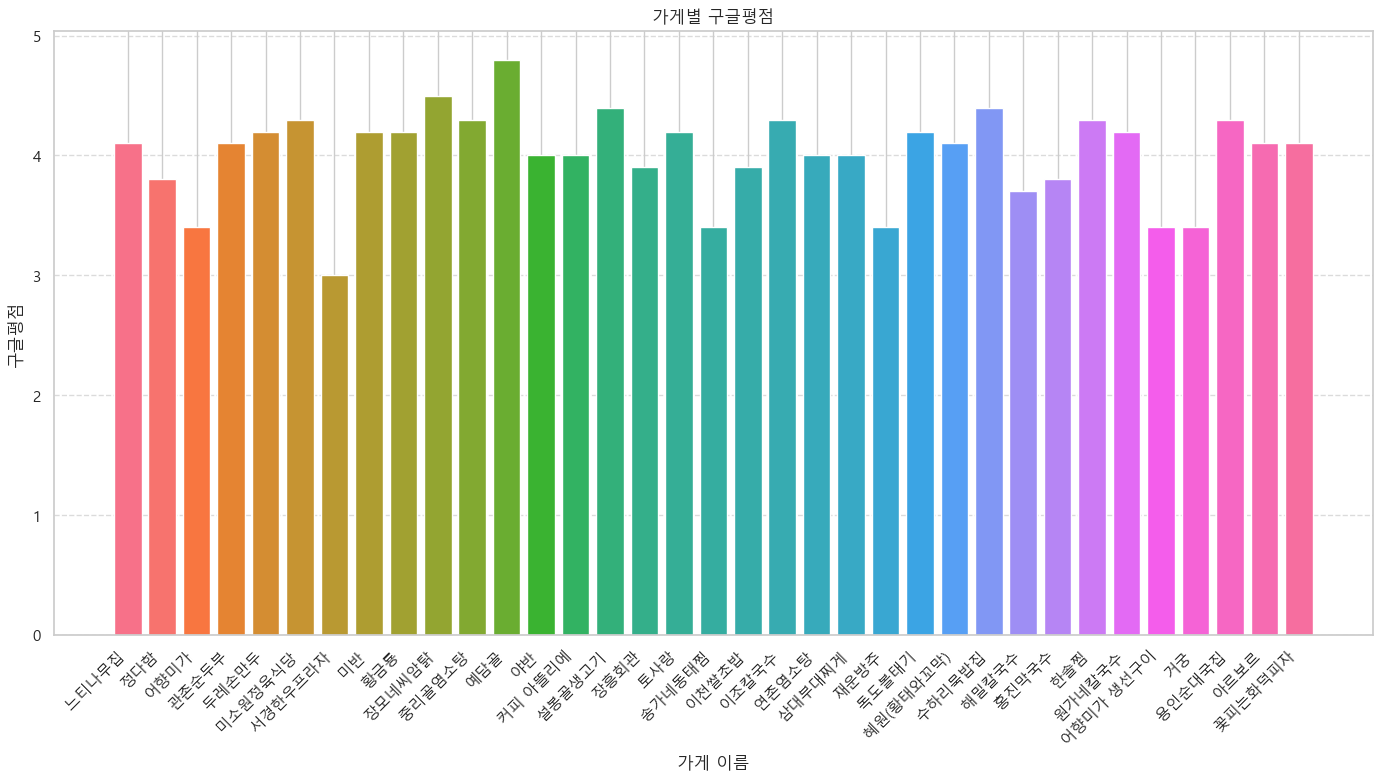

In [222]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 한글 설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['font.size'] = 12.5
matplotlib.rcParams['axes.unicode_minus'] = False

# 색상 팔레트 설정
colors = sns.color_palette('husl', n_colors=len(sorted_df))

# 이천시 업무추진비 그래프 (수직 막대 그래프)
plt.figure(figsize=(14, 8))  # 그래프 크기 조정
plt.bar(sorted_df.index, sorted_df['총합'], color=colors)
plt.xlabel('가게 이름')
plt.ylabel('방문횟수')
plt.title('이천시 업무추진비 상위 35개')
plt.xticks(rotation=45, ha='right')  # x축 라벨 회전
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 그리드 추가
plt.tight_layout()

# 그래프 표시
plt.show()

# '구글평점' 컬럼을 숫자로 변환
df_google_ratings['구글평점'] = df_google_ratings['구글평점'].astype(float)

# 가게별 구글평점 그래프 (수직 막대 그래프)
plt.figure(figsize=(14, 8))  # 그래프 크기 조정 (동일한 크기로 설정)
plt.bar(df_google_ratings.index, df_google_ratings['구글평점'], color=colors)
plt.title('가게별 구글평점')
plt.xlabel('가게 이름')
plt.ylabel('구글평점')
plt.xticks(rotation=45, ha='right')  # x축 라벨 회전
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 그리드 추가
plt.tight_layout()

# 그래프 표시
plt.show()

## 맵

In [249]:
import folium
from IPython.display import HTML

# 가게 이름과 좌표 데이터
store_data = {
    '느티나무집': (37.27410902714174, 127.43233637807403),
    '정다함': (37.287830488100035, 127.43083044733912),
    '어향미가': (37.30120630085146, 127.40794259453222),
    '관촌순두부': (37.294546707285456, 127.4185446561713),
    '두레손만두': (37.24635352785331, 127.42961082583527),
    '미소원정육식당': (37.293769630690804, 127.4191634570675),
    '서경한우프라자': (37.23343121489723, 127.36853021267542),
    '미반': (37.268408718861764, 127.43880333059796),
    '황금룡': (37.280441390813806, 127.44977418929439),
    '장모네씨암탉': (37.274597931030755, 127.433542787772),
    '중리골염소탕': (37.27412273475048, 127.43290020647072),
    '예담골': (37.2793618291271, 127.44155054337371),
    '야반': (37.29027992157778, 127.42560605550658),
    '커피 아뜰리에': (37.27953192227758, 127.44605058219068),
    '설봉골생고기': (37.27904959707137, 127.4364549072971),
    '장흥회관': (37.280214266541584, 127.43886903852368),
    '토사랑': (37.289443964218385, 127.45180693462378),
    '송가네동태찜': (37.279375616493844, 127.44026800389746),
    '이천쌀초밥': (37.29707220753458, 127.41137428795741),
    '이조칼국수': (37.27874558856544, 127.44008110436782),
    '연촌염소탕': (37.290534555915805, 127.44517668109016),
    '삼대부대찌게': (37.29641505953143, 127.3993592800468),
    '재운방주': (37.270122100941094, 127.43536894393355),
    '독도볼태기': (37.297882367606455, 127.43977808551709),
    '혜원(황태와꼬막)': (37.2900688999819, 127.45974430119615),
    '수하리묵밥집': (37.31170287706621, 127.42907995449839),
    '해밀칼국수': (37.27967747061285, 127.46270864592204),
    '홍진막국수': (37.25300274825383, 127.45739141293899),
    '한솔찜': (37.25756375612786, 127.45868151143712),
    '원가네칼국수': (37.27638385224471, 127.43548675010697),
    '어향미가 생선구이': (37.30120857282376, 127.4079369672776),
    '용인순대국집': (37.27798224201966, 127.44542691902643),
    '아르보르': (37.27405220796751, 127.43554660630024),
    '꽃피는화덕피자': (37.29663736293133, 127.4165543296362),
}

# 지도 초기 설정
m = folium.Map(location=[37.28, 127.44], zoom_start=15)  # 기본 좌표 (이천)

# 가게 이름과 좌표를 이용하여 마커 생성 및 지도에 추가
for store, coord in store_data.items():
    # 마커 외형을 커스터마이징
    marker = folium.Marker(
        location=coord,
        popup=f'<strong>{store}</strong>',
        icon=folium.Icon(color='blue', icon='info-sign')
    )
    marker.add_to(m)

# HTML 파일로 저장
m.save('custom_map.html')
m